In [1]:
# Sets how much GPU memory JAX preallocate
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.8

env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.8


In [2]:
import jax
from jax import numpy as jnp
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
import lovely_jax as lj
lj.monkey_patch()

In [3]:
import fastcore

In [4]:
import pynvml
def get_memory_free_MiB(gpu_index):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(int(gpu_index))
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    return mem_info.free // 1024 ** 2

get_memory_free_MiB(0)

11176

In [5]:
from jax import grad, value_and_grad, jit, vmap
from jax import random

In [6]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(jnp.array, [x_train, y_train, x_valid, y_valid])

## The forward and backward passes

## Foundations version

### Based on JAX documentation
https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html

#### Initialize params

In [7]:

# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 50, 50, 1]
step_size = 0.01
num_epochs = 8
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))
params

[(Array[50, 784] n=39200 x∈[-0.043, 0.042] μ=-6.460e-05 σ=0.010 gpu:0,
  Array[50] x∈[-0.024, 0.030] μ=-0.000 σ=0.011 gpu:0),
 (Array[50, 50] n=2500 x∈[-0.034, 0.033] μ=-0.000 σ=0.010 gpu:0,
  Array[50] x∈[-0.020, 0.022] μ=0.001 σ=0.010 gpu:0),
 (Array[1, 50] x∈[-0.028, 0.026] μ=-0.002 σ=0.010 gpu:0,
  Array[1] gpu:0 [-0.005])]

#### Model

In [8]:
def relu(x): return jnp.maximum(0, x)

def predict(params, input):
  # per-example prediction
  z = input
  for w, b in params[:-1]:
    outputs = w@z + b
    z = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = final_w@z + final_b
  return logits

In [9]:
preds = predict(params, x_train[0])
preds

Array[1] gpu:0 [-0.006]

In [10]:
batched_predict = vmap(predict, in_axes=(None, 0))
preds = batched_predict(params, x_train)
preds

Array[50000, 1] x∈[-0.007, -0.005] μ=-0.006 σ=0.000 gpu:0

#### Loss

In [11]:
def mse(o,t): return ((o[:,0]-t) ** 2).mean()
mse(preds, y_train)

Array gpu:0 28.202

In [12]:
def loss(params, inputs, targets):
    return mse(batched_predict(params, inputs), targets)

loss(params, x_train, y_train)

Array gpu:0 28.202

In [13]:
x = jnp.array([1,2])
y = np.array(x[:,None]==jnp.arange(10))
y, y.shape

(array([[False,  True, False, False, False, False, False, False, False,
         False],
        [False, False,  True, False, False, False, False, False, False,
         False]]),
 (2, 10))

#### Back propagation

In [14]:
step_size=0.01
@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [15]:
new_params = update(params, x_train, y_train)
new_params

[(Array[50, 784] n=39200 x∈[-0.043, 0.042] μ=-6.520e-05 σ=0.010 gpu:0,
  Array[50] x∈[-0.024, 0.030] μ=-0.000 σ=0.011 gpu:0),
 (Array[50, 50] n=2500 x∈[-0.034, 0.033] μ=-0.000 σ=0.010 gpu:0,
  Array[50] x∈[-0.020, 0.021] μ=0.001 σ=0.010 gpu:0),
 (Array[1, 50] x∈[-0.027, 0.026] μ=-0.002 σ=0.010 gpu:0,
  Array[1] gpu:0 [0.085])]

: 

In [77]:
e1=loss(params, x_train, y_train)
new_params = update(params, x_train, y_train)
e1, loss(new_params, x_train, y_train)

(Array gpu:0 28.202, Array gpu:0 27.411)

#### Training Loop

In [78]:
preds

Array[50000, 1] x∈[-0.007, -0.005] μ=-0.006 σ=0.000 gpu:0

In [79]:
# def one_hot(x, k, dtype=jnp.float32):
#   """Create a one-hot encoding of x of size k."""
#   return jnp.array(x[:, None] == jnp.arange(k), dtype)

# one_hot(preds, 10)

In [80]:
y_train, jnp.int32(.23)

(Array[50000] i32 x∈[0, 9] μ=4.449 σ=2.891 gpu:0, Array i32 gpu:0 0)

In [106]:
jnp.int32(preds), y_train.shape,y_train[:,None],jnp.mean(jnp.int32(preds) == y_train[:,None])

(Array[50000, 1] i32 all_zeros gpu:0,
 (50000,),
 Array[50000, 1] i32 x∈[0, 9] μ=4.449 σ=2.891 gpu:0,
 Array gpu:0 0.099)

In [109]:
def accuracy(params, inputs, targets):
  return jnp.mean(jnp.int32(batched_predict(params, inputs)) == targets[:,None])


In [110]:
accuracy(params, x_train, y_train)

Array gpu:0 0.099

In [ ]:

@jit
def update(params, x, y):  
  error, grads = value_and_grad(loss)(params, x, y)
  return error, [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [111]:
import time
num_epochs = 10
def train(params, num_epochs=10):
  training_start = time.time()  
  for epoch in range(num_epochs):
    epoch_start = time.time()
    error, new_params = update(params, x_train, y_train)
    params = new_params
    train_acc = accuracy(params, x_train, y_train)
    test_acc = accuracy(params, x_valid, y_valid)
    epoch_time = time.time() - epoch_start
    train_time = time.time() - training_start
    
    print(f'{epoch}/{num_epochs}, {epoch_time:0.2f} sec, {train_time:0.2f} sec')
    print("Training set loss {}".format(error))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))
    print('-------------------------------')

In [113]:
train(params, 1000)

0/1000, 0.01 sec, 0.01 sec
Training set loss 28.202253341674805
Training set accuracy 0.09863999485969543
Test set accuracy 0.09910000115633011
-------------------------------
1/1000, 0.01 sec, 0.03 sec
Training set loss 27.411394119262695
Training set accuracy 0.09863999485969543
Test set accuracy 0.09910000115633011
-------------------------------
2/1000, 0.01 sec, 0.04 sec
Training set loss 26.65247917175293
Training set accuracy 0.09863999485969543
Test set accuracy 0.09910000115633011
-------------------------------
3/1000, 0.01 sec, 0.05 sec
Training set loss 25.92398452758789
Training set accuracy 0.09863999485969543
Test set accuracy 0.09910000115633011
-------------------------------
4/1000, 0.01 sec, 0.06 sec
Training set loss 25.224512100219727
Training set accuracy 0.09863999485969543
Test set accuracy 0.09910000115633011
-------------------------------
5/1000, 0.01 sec, 0.07 sec
Training set loss 24.552783966064453
Training set accuracy 0.09863999485969543
Test set accurac

In [34]:
y_train

Array[50000] i32 x∈[0, 9] μ=4.449 σ=2.891 gpu:0

In [32]:
# from jax.scipy.special import logsumexp
# # $Sofmax(x_1,\cdots, x_n)= \frac{e^{x_i}}{\sum^{n}_1 e^{x_i}}$
# # $LogSoftmax(x_1,\cdots, x_n)= \log \frac{e^{x_i}}{\sum^{n}_1 e^{x_i}} = x_i - \log \sum^{n}_1 e^{x_i}$
# # $LogSumExp(x_1,\cdots, x_n)= \log \sum^{n}_1 e^{x_i}$
# def logsoftmax(logits): return logits + logsumexp(logits)

In [114]:
# logsoftmax(preds)

### Refactoring

In [115]:
class Linear(fastcore.transform.Transform):
  "A transform to apply linear transformation to the input"
  def __init__(self, w,b):
    self.w, self.b = w,b
  def encodes(self,x):
    "x: input data"
    return x@self.w + self.b

In [116]:
def initLinear(key, n_inp, n_out, scale=1)->Linear:
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n_inp, n_out)), scale * random.normal(b_key, (n_out,))

In [117]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50
w1,b1 =initLinear(random.PRNGKey(42), m, nh)
w2,b2 =initLinear(random.PRNGKey(43), nh,1)
n,m,c,w1,b1,w2,b2

(50000,
 784,
 Array i32 gpu:0 10,
 Array[784, 50] n=39200 x∈[-3.969, 4.653] μ=0.001 σ=1.008 gpu:0,
 Array[50] x∈[-2.799, 1.671] μ=-0.163 σ=1.007 gpu:0,
 Array[50, 1] x∈[-2.454, 2.309] μ=-0.180 σ=1.006 gpu:0,
 Array[1] gpu:0 [0.195])

In [118]:
model = fastcore.transform.Pipeline([Linear(w1,b1)])
model(x_train)

Array[50000, 50] n=2500000 x∈[-51.121, 54.617] μ=0.504 σ=8.873 gpu:0

In [119]:
@fastcore.transform.Transform
def ReLU(x): return jnp.maximum(0, x)

In [120]:
model = fastcore.transform.Pipeline([Linear(w1,b1), ReLU, Linear(w2,b2)])
x_train, model(x_train)

(Array[50000, 784] n=39200000 x∈[0., 0.996] μ=0.130 σ=0.307 gpu:0,
 Array[50000, 1] x∈[-171.777, 84.371] μ=-39.972 σ=28.197 gpu:0)

In [21]:
@jit
def update(params, x, y):  
  error, grads = value_and_grad(loss)(params, x, y)
  return error, [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [22]:
mse(model(x_train), y_train)

Array gpu:0 2.793e+03

### Based on Haiku

In [124]:
def my_stateless_apply(params, x):
  return params['w'] * x

In [121]:
# Global state which holds the parameters for the transformed function.
# get_param uses this to know where to get params from.
current_params = []

def transform(f):

  def apply_f(params, *args, **kwargs):
    current_params.append(params)
    outs = f(*args, **kwargs)
    current_params.pop()
    return outs

  return apply_f


def get_param(identifier):
  return current_params[-1][identifier]

In [122]:
dict(w=5)

{'w': 5}

In [125]:
params = dict(w=5)
my_stateless_apply(params, 5)

25

In [126]:
class MyModule:
  def apply(self, x):
    return get_param('w') * x

transform(MyModule().apply)(params, 5)

25

In [127]:
def linear(x):
  return x @ get_param('w') + get_param('b')

params = dict(w=jnp.ones((3, 5)), b=jnp.ones((5,)))
apply = transform(linear)

jax.jit(apply)(params, jnp.ones((10, 3)))

Array[10, 5] n=50 x∈[4.000, 4.000] μ=4.000 σ=0. gpu:0

In [128]:
from typing import NamedTuple, Dict, Callable
import numpy as np

In [129]:
# Since we're tracking more than just the current params,
# we introduce the concept of a frame as the object that holds
# state during a transformed execution.
frame_stack = []
frame_stack


[]

In [130]:
class Frame(NamedTuple):
  """Tracks what's going on during a call of a transformed function."""
  params: Dict[str, jnp.ndarray]
  is_initialising: bool = False

def current_frame():
  return frame_stack[-1]

class Transformed(NamedTuple):
  init: Callable
  apply: Callable

In [162]:
#Repeating the code here just to remind me 
def transform(f) -> Transformed:

  def init_f(*args, **kwargs):
    frame_stack.append(Frame({}, is_initialising=True))
    f(*args, **kwargs)
    frame = frame_stack.pop()
    return frame.params

  def apply_f(params, *args, **kwargs):
    frame_stack.append(Frame(params))
    outs = f(*args, **kwargs)
    frame_stack.pop()
    return outs

  return Transformed(init_f, apply_f)

In [132]:

def get_param(identifier, shape):
  if current_frame().is_initialising:
    current_frame().params[identifier] = np.random.normal(size=shape)

  return current_frame().params[identifier]

In [133]:
# Make printing parameters a little more readable
def parameter_shapes(params):
  return jax.tree_util.tree_map(lambda p: p.shape, params)

In [134]:

class Linear:
  def __init__(self, width):
    self._width = width

  def __call__(self, x):
    w = get_param('w', shape=(x.shape[-1], self._width))
    b = get_param('b', shape=(self._width,))
    return x @ w + b

In [136]:

init, apply = transform(Linear(4))
init??

Signature: init(*args, **kwargs)
Docstring: <no docstring>
Source:   
  def init_f(*args, **kwargs):
    frame_stack.append(Frame({}, is_initialising=True))
    f(*args, **kwargs)
    frame = frame_stack.pop()
    return frame.params
File:      /tmp/ipykernel_163207/2668621232.py
Type:      function


In [137]:
apply??

Signature: apply(params, *args, **kwargs)
Docstring: <no docstring>
Source:   
  def apply_f(params, *args, **kwargs):
    frame_stack.append(Frame(params))
    outs = f(*args, **kwargs)
    frame_stack.pop()
    return outs
File:      /tmp/ipykernel_163207/2668621232.py
Type:      function


In [175]:
NamedTuple?

Signature: NamedTuple(typename, fields=None, /, **kwargs)
Docstring:
Typed version of namedtuple.

Usage in Python versions >= 3.6::

    class Employee(NamedTuple):
        name: str
        id: int

This is equivalent to::

    Employee = collections.namedtuple('Employee', ['name', 'id'])

The resulting class has an extra __annotations__ attribute, giving a
dict that maps field names to types.  (The field names are also in
the _fields attribute, which is part of the namedtuple API.)
Alternative equivalent keyword syntax is also accepted::

    Employee = NamedTuple('Employee', name=str, id=int)

In Python versions <= 3.5 use::

    Employee = NamedTuple('Employee', [('name', str), ('id', int)])
File:      ~/.miniconda3/envs/py39/lib/python3.9/typing.py
Type:      function


In [176]:
class Employee(NamedTuple):
    name: str
    id: int

g = Employee('George', 42)
g

Employee(name='George', id=42)

In [138]:
data = jnp.ones((2, 3))
data

Array[2, 3] n=6 x∈[1.000, 1.000] μ=1.000 σ=0. gpu:0 [[1.000, 1.000, 1.000], [1.000, 1.000, 1.000]]

In [139]:
params = init(data)
parameter_shapes(params)

{'b': (4,), 'w': (3, 4)}

In [140]:
apply(params, data)

Array[2, 4] n=8 x∈[-0.827, 3.564] μ=1.658 σ=1.599 gpu:0 [[1.593, 3.564, 2.304, -0.827], [1.593, 3.564, 2.304, -0.827]]

In [177]:
frame_stack.append(Frame({}, is_initialising=True))
frame_stack

[Frame(params={}, is_initialising=True, module_counts=defaultdict(<function Frame.<lambda>.<locals>.<lambda> at 0x7f6e14c49670>, {}), call_stack=[])]

In [141]:
import dataclasses # adds some dunder methods like __init__ and __repr__
import collections

In [156]:
@dataclasses.dataclass
class Frame:
  """Tracks what's going on during a call of a transformed function."""
  params: Dict[str, jnp.ndarray]
  is_initialising: bool = False

  # Keeps track of how many modules of each class have been created so far.
  # Used to assign new modules unique names.
  module_counts: Dict[str, int] = dataclasses.field(
      default_factory=lambda: collections.defaultdict(lambda: 0))

  # Keeps track of the entire path to the current module method call.
  # Module methods, when called, will add themselves to this stack.
  # Used to give each parameter a unique name corresponding to the
  # method scope it is in.
  call_stack: list = dataclasses.field(default_factory=list)

  def create_param_path(self, identifier) -> str:
    """Creates a unique path for this param."""
    return '/'.join(['~'] + self.call_stack + [identifier])

  def create_unique_module_name(self, module_name: str) -> str:
    """Assigns a unique name to the module by appending its number to its name."""
    number = self.module_counts[module_name]
    self.module_counts[module_name] += 1
    return f"{module_name}_{number}"

frame_stack = []
def current_frame():
  return frame_stack[-1] if len(frame_stack)>0 else []

current_frame()

[]

In [147]:
class Module:
  def __init__(self):
    # Assign a unique (for the current `transform` call)
    # name to this instance of the module.
    self._unique_name = current_frame().create_unique_module_name(
        self.__class__.__name__)

def module_method(f):
  """A decorator for Module methods."""

  def wrapped(self, *args, **kwargs):
    """A version of f that lets the frame know it's being called."""
    # Self is the instance to which this method is attached.
    module_name = self._unique_name
    call_stack = current_frame().call_stack
    call_stack.append(module_name)
    call_stack.append(f.__name__)
    outs = f(self, *args, **kwargs)
    assert call_stack.pop() == f.__name__
    assert call_stack.pop() == module_name
    return outs
  return wrapped

In [157]:
def transform(f) -> Transformed:

  def init_f(*args, **kwargs):
    frame_stack.append(Frame({}, is_initialising=True))
    f(*args, **kwargs)
    frame = frame_stack.pop()
    return frame.params

  def apply_f(params, *args, **kwargs):
    frame_stack.append(Frame(params))
    outs = f(*args, **kwargs)
    frame_stack.pop()
    return outs

  return Transformed(init_f, apply_f)

In [149]:

def get_param(identifier, shape):
  frame = current_frame()
  param_path = frame.create_param_path(identifier)

  if frame.is_initialising:
    frame.params[param_path] = np.random.normal(size=shape)

  return frame.params[param_path]


class Linear(Module):

  def __init__(self, width):
    super().__init__()
    self._width = width
    
  @module_method  
  def __call__(self, x):
    w = get_param('w', shape=(x.shape[-1], self._width))
    b = get_param('b', shape=(self._width,))
    return x @ w + b

In [150]:
init, apply = transform(lambda x: Linear(4)(x))

params = init(data)
parameter_shapes(params)

{'~/Linear_0/__call__/b': (4,), '~/Linear_0/__call__/w': (3, 4)}

In [163]:
apply(params, data)

Array[2, 4] n=8 x∈[-1.179, 3.948] μ=0.996 σ=2.137 gpu:0 [[-1.179, 2.111, 3.948, -0.894], [-1.179, 2.111, 3.948, -0.894]]

In [164]:
class MLP(Module):

  def __init__(self, widths):
    super().__init__()
    self._widths = widths

  @module_method
  def __call__(self, x):
    for w in self._widths:
      out = Linear(w)(x)
      x = jax.nn.sigmoid(out)
    return out

In [165]:
init, apply = transform(lambda x: MLP([3, 5])(x))
parameter_shapes(init(data))

{'~/MLP_0/__call__/Linear_0/__call__/b': (3,),
 '~/MLP_0/__call__/Linear_0/__call__/w': (3, 3),
 '~/MLP_0/__call__/Linear_1/__call__/b': (5,),
 '~/MLP_0/__call__/Linear_1/__call__/w': (3, 5)}

#### Training Loop (Haiku)

In [171]:
# Data: a quadratic curve.
xs = np.linspace(-2., 2., num=128)[:, None]  # Generate array of shape (128, 1).
ys = xs ** 2

# Model
def mlp(x):
  return MLP([128, 50, 1])(x)

init, forward = transform(mlp)
params = init(xs)
parameter_shapes(params)

{'~/MLP_0/__call__/Linear_0/__call__/b': (128,),
 '~/MLP_0/__call__/Linear_0/__call__/w': (1, 128),
 '~/MLP_0/__call__/Linear_1/__call__/b': (50,),
 '~/MLP_0/__call__/Linear_1/__call__/w': (128, 50),
 '~/MLP_0/__call__/Linear_2/__call__/b': (1,),
 '~/MLP_0/__call__/Linear_2/__call__/w': (50, 1)}

In [172]:
# Loss function and update function
def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.003

@jax.jit
def update(params, x, y):
  grads = jax.grad(loss_fn)(params, x, y)
  return jax.tree_util.tree_map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

In [173]:
for _ in range(5000):
  params = update(params, xs, ys)

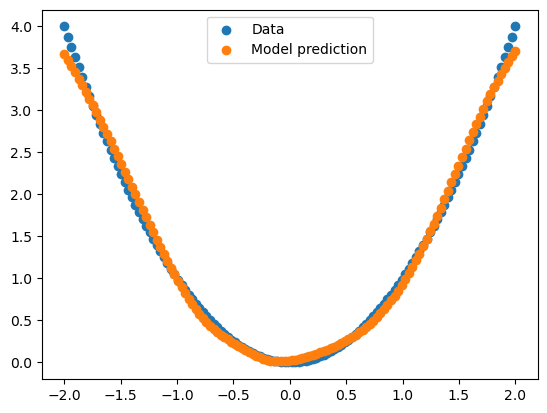

In [174]:
plt.scatter(xs, ys, label='Data')
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend()
plt.show()

In [ ]:
# predict model, inputs
inputs = x_train
z = lin(w1,b1)(inputs)
z = relu(z)
z = lin(w2,b2)(z)

# model = lin(w1,b1) | relu | lin(w2,b2)  
# predict(model, inputs) = model(inputs), model -> inputs -> outputs
# evaluate (model, loss, inputs, targets) -> msg
# update: msg -> model -> model

# @jit
# def update(params, x, y): params
#   grads = grad(loss)(params, x, y)
#   return [(w - step_size * dw, b - step_size * db)
#           for (w, b), (dw, db) in zip(params, grads)]

In [ ]:
# evaluate model, loss, inputs, targets


In [ ]:
# from fastai.vision.all import *

In [ ]:
# Transform

In [ ]:
w1,b1 = initLinear(random.PRNGKey(42), 784,50)
w1,b1

In [ ]:
w2,b2 = initLinear(random.PRNGKey(43), 50,1)
w2,b2

In [ ]:
model = fastcore.transform.Pipeline([ReLU])

In [ ]:
w1, model(w1)

In [ ]:
model = fastcore.transform.Pipeline([Linear(w1,b1), ReLU, Linear(w2,b2)])
x_train, model(x_train)

In [ ]:
o = model(x_train)
o.shape

In [ ]:
def mse(o,t): return (o)

In [ ]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (n,))

random_layer_params(784,50, random.PRNGKey(42))

In [ ]:
  sizes = [784, 512, 512, 10]
  keys = random.split(random.PRNGKey(42), len(sizes))
  keys

In [ ]:
[(m, n) for m, n in zip(sizes[:-1], sizes[1:])]

In [ ]:
# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [ ]:
params = init_network_params(sizes, random.PRNGKey(42))
params

In [ ]:
from jax.scipy.special import logsumexp

def relu(x): return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image
  for w, b in params[:-1]:
    outputs = activations@w + b
    activations = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = activations@final_w + final_b
  return logits - logsumexp(logits)

In [ ]:
# This works on single examples
random_flattened_image = random.normal(random.PRNGKey(1), (28 * 28,))
preds = predict(params, random_flattened_image)
preds

In [ ]:
batched_predict = vmap(predict, in_axes=(None, 0))

In [ ]:
random_flattened_images = random.normal(random.PRNGKey(1), (10, 28 * 28))
batched_preds = batched_predict(params, random_flattened_images)
batched_preds

In [ ]:
a = random.normal(random.PRNGKey(42), (50,10))
b = random.normal(random.PRNGKey(43), (10,10))
a,b

In [ ]:
a@b, jnp.dot(a,b)

In [ ]:
jnp.arange(10)

In [ ]:
a = jnp.array([10,20,30])
a[:,None]

In [ ]:
def one_hot(y, k, dtype=jnp.float32):
  """Create a one-hot encoding of y of size k klasses"""
  return jnp.array(y[:, None] == jnp.arange(k), dtype)


In [ ]:
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

In [ ]:
from functools import partial

In [ ]:
train_labels, test_labels = map(partial(one_hot, k=10), (y_train, y_valid))
train_images, test_images = x_train, x_valid
train_images, train_labels, test_images, test_labels

In [ ]:
train_labels-train_labels

In [ ]:
jnp.mean(train_labels -train_labels)

In [ ]:
def mse(o, t): return jnp.mean((o-t)**2)

In [ ]:
def loss(params, images, targets): return mse(batched_predict(params, images), targets)

In [ ]:
loss(params, train_images, train_labels), grad(loss)(params, train_images, train_labels)

In [ ]:
step_size = 0.01
@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [ ]:
num_epochs = 8
n_targets = 10
# batch_size = 128
import time

for epoch in range(num_epochs):
  start_time = time.time()
  x, y = train_images, train_labels
  params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

In [ ]:

n,m = x_train.shape
c = y_train.max()+1
n,m,c

In [ ]:
# num hidden
nh = 50

In [ ]:
jax.random.normal(key, (m,nh), dtype=jax.numpy.float32)

In [ ]:
w1 = jax.random.normal(key, (m,nh), dtype=jax.numpy.float32)
b1 = jnp.zeros(nh)
w2 = jax.random.normal(key, (nh,1), dtype=jax.numpy.float32)
b2 = jnp.zeros(1)

In [ ]:
def lin(x, w, b): return x@w + b

In [ ]:
x_valid, w1, b1

In [ ]:
t = lin(x_valid, w1, b1)
t

In [ ]:
def relu(x): return jnp.maximum(0, x)

In [ ]:
t = relu(t)
t

In [ ]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    return lin(l2, w2, b2)

In [ ]:
res = model(x_valid)
res

### Loss function: MSE

(Of course, `mse` is not a suitable loss function for multi-class classification; we'll use a better loss function soon. We'll use `mse` for now to keep things simple.)

In [ ]:
res.shape,y_valid.shape

In [ ]:
(res-y_valid).shape

We need to get rid of that trailing (,1), in order to use `mse`.

In [ ]:
res[:,0].shape

In [ ]:
res.squeeze().shape

In [ ]:
(res[:,0]-y_valid).shape

In [ ]:
jnp.float32(y_train)

In [ ]:
y_train,y_valid = map(jnp.float32, (y_train,y_valid))

preds = model(x_train)
preds

In [ ]:
def mse(output, targ): return ((output[:,0]-targ)** 2).mean()

In [ ]:
mse(preds, y_train)

In [ ]:
sizes = [784, 512, 512, 10]
sizes[:-1], sizes[1:]

In [ ]:
list(zip(sizes[:-1], sizes[1:]))

In [ ]:
# Global state which holds the parameters for the transformed function.
# get_param uses this to know where to get params from.
current_params = []

def transform(f):

  def apply_f(params, *args, **kwargs):
    current_params.append(params)
    outs = f(*args, **kwargs)
    current_params.pop()
    return outs

  return apply_f


def get_param(identifier):
  return current_params[-1][identifier]

### Gradients and backward pass

In [ ]:
from sympy import symbols,diff
x,y = symbols('x y')
diff(x**2, x)

In [ ]:
diff(3*x**2+9, x)

In [ ]:
# def lin(x, w, b): return x@w + b

In [ ]:
def lin_grad(inp, out, w, b):
    # grad of matmul with respect to input
    inp.g = out.g @ w
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [ ]:
def forward_and_backward(inp, targ):
    # forward pass:
    l1 = lin(inp, w1, b1)
    l2 = relu(l1)
    out = lin(l2, w2, b2)
    diff = out[:,0]-targ
    loss = (res ** 2).mean()
    
    # backward pass:
    out.g = 2.*diff[:,None] / inp.shape[0]
    lin_grad(l2, out, w2, b2)
    l1.g = (l1>0).float() * l2.g
    lin_grad(inp, l1, w1, b1)

In [ ]:
forward_and_backward(x_train, y_train)

In [ ]:
# Save for testing against later
def get_grad(x): return x.g.clone()
chks = w1,w2,b1,b2,x_train
grads = w1g,w2g,b1g,b2g,ig = tuple(map(get_grad, chks))

We cheat a little bit and use PyTorch autograd to check our results.

In [ ]:
def mkgrad(x): return x.clone().requires_grad_(True)
ptgrads = w12,w22,b12,b22,xt2 = tuple(map(mkgrad, chks))

In [ ]:
def forward(inp, targ):
    l1 = lin(inp, w12, b12)
    l2 = relu(l1)
    out = lin(l2, w22, b22)
    return mse(out, targ)

In [ ]:
loss = forward(xt2, y_train)
loss.backward()

In [ ]:
for a,b in zip(grads, ptgrads): test_close(a, b.grad, eps=0.01)

## Refactor model

### Layers as classes

In [ ]:
# Global state which holds the parameters for the transformed function.
# get_param uses this to know where to get params from.
current_params = []

def transform(f):

  def apply_f(params, *args, **kwargs):
    current_params.append(params)
    outs = f(*args, **kwargs)
    current_params.pop()
    return outs

  return apply_f


def get_param(identifier):
  return current_params[-1][identifier]

In [ ]:
class Relu():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.)
        return self.out
    
    def backward(self): self.inp.g = (self.inp>0).float() * self.out.g

In [ ]:
class Lin():
    def __init__(self, w, b): self.w,self.b = w,b

    def __call__(self, inp):
        self.inp = inp
        self.out = lin(inp, self.w, self.b)
        return self.out

    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = self.inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

In [ ]:
class Mse():
    def __call__(self, inp, targ):
        self.inp,self.targ = inp,targ
        self.out = mse(inp, targ)
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [ ]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [ ]:
model = Model(w1, b1, w2, b2)

In [ ]:
loss = model(x_train, y_train)

In [ ]:
model.backward()

In [ ]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

### Module.forward()

In [ ]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out

    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)
    def bwd(self): raise Exception('not implemented')

In [ ]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [ ]:
class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
    def forward(self, inp): return inp@self.w + self.b
    def bwd(self, out, inp):
        inp.g = self.out.g @ self.w.t()
        self.w.g = inp.t() @ self.out.g
        self.b.g = self.out.g.sum(0)

In [ ]:
class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.shape[0]

In [ ]:
model = Model(w1, b1, w2, b2)

In [ ]:
loss = model(x_train, y_train)

In [ ]:
model.backward()

In [ ]:
test_close(w2g, w2.g, eps=0.01)
test_close(b2g, b2.g, eps=0.01)
test_close(w1g, w1.g, eps=0.01)
test_close(b1g, b1.g, eps=0.01)
test_close(ig, x_train.g, eps=0.01)

### Autograd

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
class Linear(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.w = torch.randn(n_in,n_out).requires_grad_()
        self.b = torch.zeros(n_out).requires_grad_()
    def forward(self, inp): return inp@self.w + self.b

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [Linear(n_in,nh), nn.ReLU(), Linear(nh,n_out)]
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return F.mse_loss(x, targ[:,None])

In [ ]:
model = Model(m, nh, 1)
loss = model(x_train, y_train)
loss.backward()

In [ ]:
l0 = model.layers[0]
l0.b.grad